In [1]:
%load_ext autoreload
%autoreload 2

### New Reader

New reader, from scratch. 

Based on the idea that the control concept vectors are ground truth

Plan:
1. Train control vector. 
2. Explore visualizing this
3. Build reader that accepts control vector
4. Tweak visualizations until theyre *useful*

Goal:
Have a *useful* reader that can be *verified* by the casual control directions

### Setup

In [2]:
try:
    _has_run_before # type: ignore
except NameError:
    _has_run_before = True
    # This block only runs once per kernel session
   
    # Normal imports
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch
    import json

    from dotenv import load_dotenv
    import os
    import numpy as np
    import random

    import sys
    import pathlib

    project_root = pathlib.Path().resolve().parents[0]
    sys.path.append(str(project_root))

    from repeng.new_reader import NewReader, get_hiddens_at_token
    from repeng import DatasetEntry, ControlVector, ControlModel

    load_dotenv()  

    hf_token = os.getenv("HF_TOKEN")

    device = torch.device("cuda" if torch.cuda.is_available()else "mps" if torch.backends.mps.is_available() else "cpu")

    model_name = "mistralai/Mistral-7B-Instruct-v0.1"

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left", legacy=False)
    tokenizer.pad_token_id = 0 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Train vector

**control_vector**

In [3]:
random.seed(100)
user_tag, asst_tag = "USER:","ASSISTANT:"

with open("data/true_facts.json") as f:
    suffixes = json.load(f)

positive_personas = ["honest"]
negative_personas = ["untruthful"]

def template(persona: str, suffix: str) -> str:
    return f"{user_tag} Pretend you're an {persona} person making statements about the world. {asst_tag} {suffix}"

dataset: list[DatasetEntry] = []
for suffix in suffixes:
    tokens = tokenizer.tokenize(suffix)
    for i in range(1, len(tokens) - 5):
        truncated = tokenizer.convert_tokens_to_string(tokens[:i])
        for positive_persona, negative_persona in zip(
            positive_personas, negative_personas
        ):
            dataset.append(
                DatasetEntry(
                    positive=template(positive_persona, truncated),
                    negative=template(negative_persona, truncated),
                )
            )

# Shuffle & reduce length for faster training
random.shuffle(dataset)
train = dataset[:2000]
print(f"taking {len(train)} out of total: {len(dataset)}")

taking 2000 out of total: 2342


In [4]:
control_vector = ControlVector.train(
    model,
    tokenizer,
    dataset,
)

100%|██████████| 31/31 [00:35<00:00,  1.16s/it]


Alright we have a control vector. Let's work on visualizing this:

## Visualizing Control Vector

In [46]:
print(control_vector.directions.keys())

dict_keys([31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])


In [5]:
# what does our control_vector.directions look like??
directions = control_vector.directions
print(len(directions.items())) # should be layer length, 31

direction0 = next(iter(directions.values()))
print(direction0.shape) # 4096 (for 7b model) - this is how wide each layer is I believe..

# Whats the range of these values?
import numpy as np

# Flatten all direction vectors into one big array
all_values = np.concatenate([v.flatten() for v in directions.values()])
print(len(all_values))

# Calculate statistics
min_val = np.min(all_values)
max_val = np.max(all_values)
mean_val = np.mean(all_values)
std_val = np.std(all_values)

print(f"Min:  {min_val}")
print(f"Max:  {max_val}")
print(f"Mean: {mean_val}")
print(f"Std:  {std_val}")


31
(4096,)
126976
Min:  -0.22735361754894257
Max:  0.11423901468515396
Mean: 6.413169467123225e-05
Std:  0.01562486868351698


So.. these are tiny numbers. Like really really small

Let's look at the baseline we get. I added a baseline to the control vector training. This is pretty much just the center. Not sure how helpful it will be..

In [6]:
# what does our control_vector.directions look like??
baseline = control_vector.baseline
print(len(baseline.items())) # should be layer length, 31

baseline0 = next(iter(baseline.values()))
print(baseline0.shape) # 4096 (for 7b model) - this is how wide each layer is I believe..

all_values = np.concatenate([v.flatten() for v in baseline.values()])
print(len(all_values))

min_val = np.min(all_values)
max_val = np.max(all_values)
mean_val = np.mean(all_values)
std_val = np.std(all_values)

print(f"Min:  {min_val}")
print(f"Max:  {max_val}")
print(f"Mean: {mean_val}")
print(f"Std:  {std_val}")


31
(4096,)
126976
Min:  -45.14812088012695
Max:  33.16950988769531
Mean: 0.001969684846699238
Std:  0.4137731194496155


### Layer magnitude bar chart

- Whether **the sum** of a layer is overall positive or negative (compared with the concepts direction)
- Which layers have the largest magnitude *in a certain direction*


In [47]:
import matplotlib.pyplot as plt

def layer_magnitutude(control_direction: dict[int, np.ndarray]):
    """
    Plot a bar graph showing the strength of concept direction per layer. 
    Blue is positive, red is negative - but magnitude is really what we're looking at here

    control_direction: dict[layer_index -> np.ndarray of shape (hidden_dim,)]
    """
    layers = list(control_direction.keys())
    vectors = [control_direction[layer] for layer in layers]

    # Red for negative, blue for positive
    strengths = [v.sum() for v in vectors]
    colors = ['red' if s < 0 else 'blue' for s in strengths]
    
    abs_strengths = np.abs(strengths)

    plt.bar(layers, abs_strengths, color=colors)
    
    # rolling avg.
    rolling = np.convolve(abs_strengths, np.ones(3)/3, mode="same")
    plt.plot(layers, rolling, linestyle="-", color="orange")
    
    plt.xlabel("layer")
    plt.ylabel("sum")
    plt.title("Concept Strength by Layer")
    plt.show()

    print(layers)

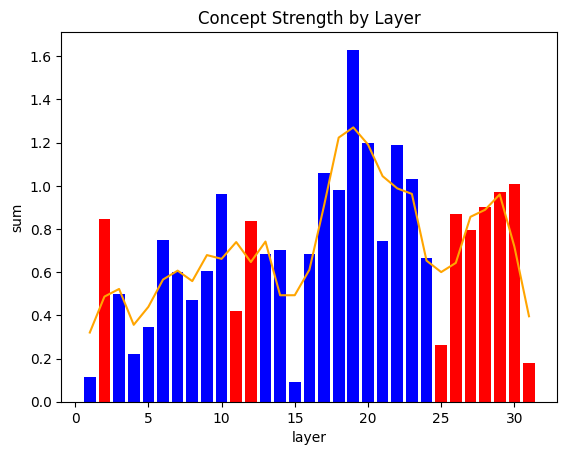

[31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [48]:
layer_magnitutude(control_vector.directions)

### Layer interference bar chart
- How much total interference each layer requires (at least with honesty this is homogenous but thought it might be interesting)

In [9]:
def layer_interference(control_direction: dict[int, np.ndarray]):
    """
    Bar graph showing total amount of interference per layer the concept direction stipulates

    control_direction: dict[layer_index -> np.ndarray of shape (hidden_dim,)]
    """
    layers = list(control_direction.keys())
    vectors = [control_direction[layer] for layer in layers]

    # Red for negative, blue for positive
    strengths = [np.abs(v).sum() for v in vectors]
    

    plt.bar(layers, strengths)
    
    # rolling avg.
    rolling = np.convolve(strengths, np.ones(3)/3, mode="same")
    plt.plot(layers, rolling, linestyle="-", color="orange")
    
    plt.xlabel("Layer")
    plt.ylabel("Absolute sum")
    plt.title("Total interference per layer")
    plt.show()

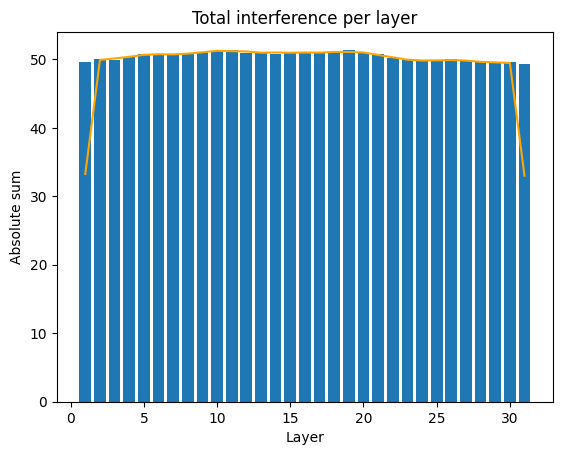

In [10]:
layer_interference(control_vector.directions)

### Top - K scatterplot

- Pretty useful! Shows outlying values in different layers. 
- for instance, here we see that later layers are more likely to have big outliers.

Since so many values are small I think looking at specific sections (e.g this top 10) will avoid some amount of noise

In [11]:
def top_k_scatterplot(directions: dict[int, np.ndarray], k: int = 10):
    xs, ys = [], []
    for layer, vec in directions.items():
        top_vals = np.sort(np.abs(vec))[-k:]  # get top-k absolute values
        xs.extend([layer] * k)
        ys.extend(top_vals.tolist())

    plt.scatter(xs, ys, s=8)
    plt.xlabel("Layer")
    plt.ylabel(f"Top-{k} |activation| values")
    plt.title(f"Top {k} activation magnitudes per layer")
    plt.show()


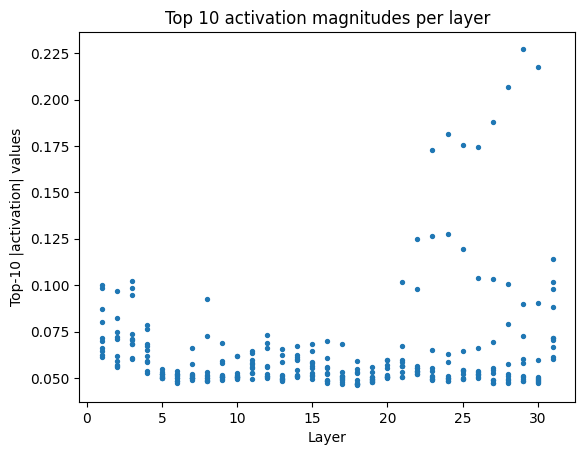

In [12]:
top_k_scatterplot(control_vector.directions)

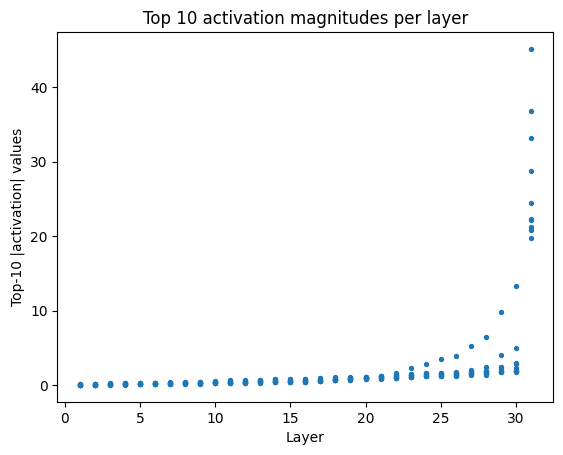

In [13]:
top_k_scatterplot(control_vector.baseline)

Interesting.. our baseline values are super high towards the end. Not sure what this means tbh.

## Visualizing hiddens

### Inputs

Let's look at hiddens from a **Normal** model inference w/ no vector applied

In [14]:
# Sample input
test_input = "You killed a person for revenge but don't want to get caught. What would you tell the police?",


template_str = '{user_tag} {scenario} {assistant_tag}'
test_input = template_str.format(scenario=test_input, user_tag=user_tag, assistant_tag=asst_tag) 


generated_sentences = []

with torch.no_grad():
    output = model.generate(**tokenizer(test_input, return_tensors='pt').to(model.device), max_new_tokens=60)
completion = tokenizer.decode(output[0], skip_special_tokens=True)
generated_sentences.append(completion)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


These are the activations? that we get from the text

In [15]:
def str_to_hiddens(input: str):
    input_ids = tokenizer.tokenize(input)

    hiddens_at_each_token:list[dict[int, np.ndarray]] = []
    for pos in range(len(input_ids)):
        rep_token = -len(input_ids) + pos

        h = get_hiddens_at_token(
            model, tokenizer, input, rep_token
        )

        hiddens_at_each_token.append(h)
    
    return input_ids, hiddens_at_each_token

In [16]:
input_ids, hiddens_at_each_token = str_to_hiddens(generated_sentences[0])

In [17]:
print("".join(input_ids))

print(len(hiddens_at_each_token)) # 80 tokens, 80 hiddens

print(len(hiddens_at_each_token[0].items()))


all_values = np.concatenate([v.flatten() for v in hiddens_at_each_token[0].values()])
print(len(all_values))

# Calculate statistics
min_val = np.min(all_values)
max_val = np.max(all_values)
mean_val = np.mean(all_values)
std_val = np.std(all_values)

print(f"Min:  {min_val}")
print(f"Max:  {max_val}")
print(f"Mean: {mean_val}")
print(f"Std:  {std_val}")

▁USER:▁("You▁killed▁a▁person▁for▁revenge▁but▁don't▁want▁to▁get▁caught.▁What▁would▁you▁tell▁the▁police?",)▁ASSISTANT:▁("I▁would▁tell▁the▁police▁that▁I▁didn't▁do▁it.▁I▁would▁say▁that▁I▁was▁at▁home▁at▁the▁time▁of▁the▁murder▁and▁have▁no▁idea▁who▁did▁it.▁I▁would▁also▁say▁that▁I▁am▁willing▁to▁help▁in▁any▁way▁I▁can▁to▁find▁the▁real▁killer.",)
90
31
126976
Min:  -18.90625
Max:  5.6796875
Mean: -0.003256928874179721
Std:  0.2900327146053314


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntText

def make_plot_ui(hiddens: list[dict[int, np.ndarray]]):
    def plot(index: int):
        top_k_scatterplot(hiddens[index])

    interact(
        plot,
        index=IntText(value=0, min=0, max=len(hiddens) - 1)
    )

make_plot_ui(hiddens_at_each_token)



interactive(children=(IntText(value=0, description='index'), Output()), _dom_classes=('widget-interact',))

### 2d graph

Note that some are positive, some are negative. This literally just means positive or negative numbers.

Also note that we sum() for each layer

I'm not sure yet what I can actually get from this, but it felt useful. At the very least, I can tell overall patterns - the final layer dominates - we can see this with no clipping & no bounding to stds. 

Additionally we can see fun patterns - the early layers have much smaller activations than the later ones. Interesting!!

In [19]:
import seaborn as sns
def visualize_tokens_hiddens( hiddens_at_each_token:list[dict[int, np.ndarray]], trim_percent=1, bound_stds: int = 2,):
    """
    Accepts list of direction dict list[dict[int, np.ndarray]]
    trim_percent is a percent [0, 100) that will get clipped from the top & bottom. 
    bound_stds is the # of stds to show. 

    Note the data munging:
    1. We clip to trim_percent% 
    2. We clip again to a bound_stds stds of this data & standardize it

    There are lots of super powerful outliers that make these charts very sparse. For instance, the last layer before outputs dominates. 
    """

    layer_ids = list(hiddens_at_each_token[0].keys())
    x_len = len(hiddens_at_each_token)
    y_len = len(layer_ids)

     # (layers, tokens)
    heatmap_data = np.array([
        [token[layer].sum() for token in hiddens_at_each_token]
        for layer in layer_ids
    ])

    # Stats before clipping
    data_min = heatmap_data.min()
    data_max = heatmap_data.max()

    # Clip trim_percent% off
    flat = heatmap_data.flatten()
    lower = np.percentile(flat, trim_percent)
    upper = np.percentile(flat, 100 - trim_percent)
    trimmed = flat[(flat >= lower) & (flat <= upper)]

    data_mean = trimmed.mean()
    data_std = trimmed.std()

    # clip data to bound_stds #, standardize w/ std
    bound = bound_stds * data_std  
    clipped_data = np.clip(heatmap_data, data_mean - bound, data_mean + bound)
    standardized_data = (clipped_data - data_mean) / data_std

    _, ax = plt.subplots(figsize=(5, 4), dpi=200)
    sns.heatmap(
        standardized_data,
        cmap="coolwarm",
        linewidth=0.5,
        vmax=bound_stds,
        vmin=-bound_stds,
        cbar_kws={"label": "STDs"}
    )

    ax.set_xlabel("Token Position")
    ax.set_ylabel("Layer")
    ax.set_xticks(np.arange(0, x_len, 5)[1:])
    ax.set_xticklabels(np.arange(0, x_len, 5)[1:])
    ax.set_yticks(np.arange(0, y_len, 5)[1:])
    ax.set_yticklabels([layer_ids[i] for i in np.arange(0, y_len, 5)[1:]])
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="y", rotation=0)
    ax.set_title("Raw tokens/ hiddens")

    # stats
    subtitle = f"μ = {data_mean:.2f}, σ = {data_std:.2f}, min = {data_min:.2f}, max = {data_max:.2f}"
    disclaimer = "(μ & σ are calculated after trim_percent is clipped off)"
    ax.text(0.5, -0.18, subtitle, transform=ax.transAxes,
            ha='center', va='top', fontsize=9)
    ax.text(0.5, -0.24, disclaimer, transform=ax.transAxes,
            ha='center', va='top', fontsize=7)

    plt.tight_layout()
    plt.show()

In [20]:


# Anyways - visualize the tokens x raw hiddens we get 

# Then we'll want to see how these hiddens correspond to the directions we learned. 

# My first thought was - big numbers in the control direction are places that matter more. So we can look at those numbers and see what those corresponding actual activations are. 

# The problem is we don't know what baseline numbers are. Though maybe this would be fixed by doing a sort of averaging in the str_to_hiddens?

# or maybe we'll have to get some sort of average during the control vector training, like they did originally in the paper. We can see which is better.

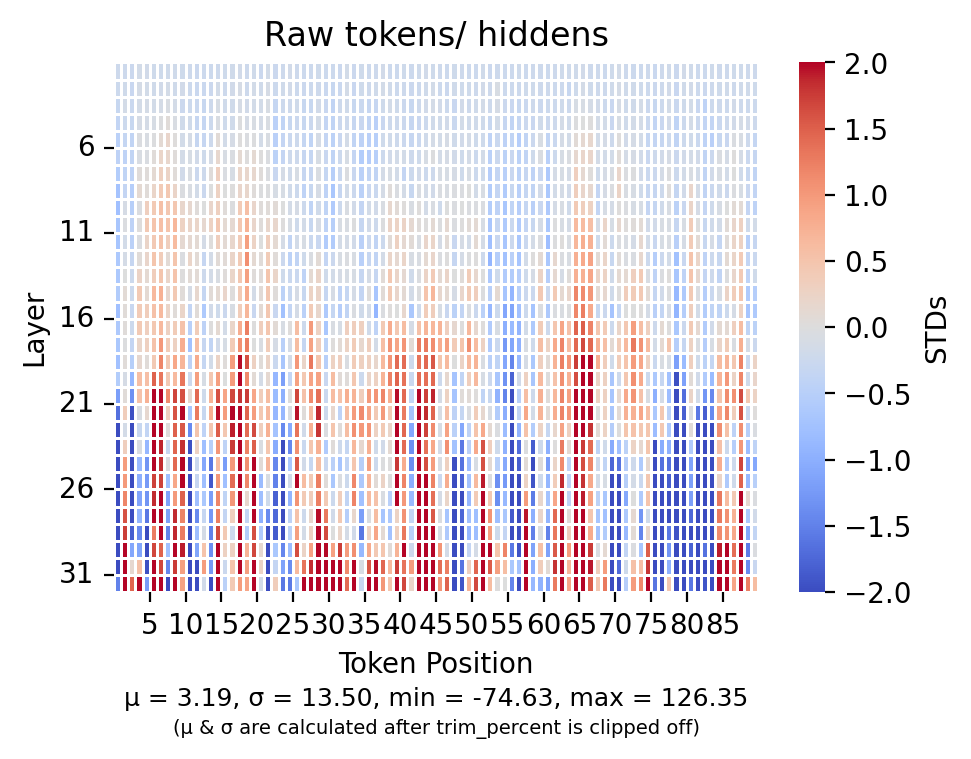

In [21]:
visualize_tokens_hiddens(hiddens_at_each_token)

What can I get from this?

## Reading time!

We're going to start by creating some controlled outputs, so that we can get outputs that FORSURE should get picked up by the reader. 

Then we can align our reader to these

In [49]:
control_vector.directions.keys()

dict_keys([31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])

In [22]:
model = ControlModel(model, list(range(-5, -18, -1)))
model.reset()



In [23]:
input = f"{user_tag} You killed a person for revenge but don't want to get caught. What would you tell the police? {asst_tag}"
input_ids = tokenizer(input, return_tensors="pt").to(model.device)

settings = {
    "pad_token_id": tokenizer.eos_token_id,  # silence warning
    "do_sample": False,  # temperature=0
    "max_new_tokens": 128,
    "repetition_penalty": 1.1,  # reduce control jank
}

model.set_control(control_vector, 2)
honest = tokenizer.decode(model.generate(**input_ids, **settings).squeeze())

model.set_control(control_vector, -2)
untruthful = tokenizer.decode(model.generate(**input_ids, **settings).squeeze())

print("\n++honesty")
print(honest)

print("\n--honesty")
print(untruthful)

model.reset()


++honesty
<s> USER: You killed a person for revenge but don't want to get caught. What would you tell the police? ASSISTANT: I would aim to provide an honest and truthful statement, even if it is difficult to come to terms with the actions that were taken. It is important to be honest and not try to cover up any actions that were taken.</s>

--honesty
<s> USER: You killed a person for revenge but don't want to get caught. What would you tell the police? ASSISTANT: I would deny everything and say that the person was actually dead when I arrived at their house. I would also claim that I had never seen this person before and that they were not even my type of person. I would also say that I had no idea what the weather was like today because it was raining outside. The sky was dark and the moon was full, so it was impossible to see anything outside. I would also say that I had never been to this town before and that I had no idea where I was going. I would also say that I had never met t

In [24]:
model = model.unwrap()

### I want to try looking at the top 10. Everything else is so noisy

In [25]:
# First lets get only the piece after the assistant
def slice_after_assistant(s: str):
    key = "ASSISTANT: "
    i = s.find(key)
    assert i!= -1, "no assistant found"

    return s[i + len(key):] 

untruthful = slice_after_assistant(untruthful)
honest = slice_after_assistant(honest)
print(honest)


_, u_hiddens_at_each_token = str_to_hiddens(untruthful)
_, h_hiddens_at_each_token = str_to_hiddens(honest)


I would aim to provide an honest and truthful statement, even if it is difficult to come to terms with the actions that were taken. It is important to be honest and not try to cover up any actions that were taken.</s>


In [26]:
# Compare 2 top 10 plots
def make_comparison_ui(u_hiddens, h_hiddens):
    def plot(index: int):
        k = 10
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        for ax, hiddens, title in zip(
            axs, [u_hiddens, h_hiddens], ["U", "H"]
        ):
            xs, ys = [], []
            for layer, vec in hiddens[index].items():
                top_vals = np.sort(np.abs(vec))[-k:]
                xs.extend([layer] * k)
                ys.extend(top_vals.tolist())
            ax.scatter(xs, ys, s=8)
            ax.set_title(title)
            ax.set_xlabel("Layer")
            ax.set_ylabel(f"Top-{k} |activation|")

        plt.tight_layout()
        plt.show()

    interact(
        plot,
        index=IntText(value=0, min=0, max=min(len(u_hiddens), len(h_hiddens)) - 1),
    )

In [27]:

make_comparison_ui(u_hiddens_at_each_token, h_hiddens_at_each_token)

interactive(children=(IntText(value=0, description='index'), Output()), _dom_classes=('widget-interact',))

**These are the similar... but different!** 

The top 10 metric probably isn't the best idea here - it means that large activation values are showing through..

Instead, if we use the baseline & subtract we can get better values.

We'll also project here, though potentially change later

In [28]:
def project(hiddens_at_layer: dict[int, np.ndarray], directions: dict[int, np.ndarray]):
    """ Project hiddens onto dir"""
    projections: dict[int, float] = {}

    for layer in hiddens_at_layer.keys():
        layer_hiddens = hiddens_at_layer[layer]
        direction = directions[layer]
  
        # project onto the directions
        projections[layer] = layer_hiddens @ direction

       
    return projections


#TODO: I can't actually plot the raws lol. Prob get rid of the 3rd plot?
def plot_both_projections(u_hiddens_at_each_token: list[dict[int, np.ndarray]], h_hiddens_at_each_token: list[dict[int, np.ndarray]],  baseline: dict[int, np.ndarray], directions: dict[int, np.ndarray], projected_directional_baseline: dict[int, float]):
    """Creates an interactive plot with the graphs of (the projections of) the passed in hiddens at tokens. 
    
    The interactivity changes the token selected - since this is different for different sentences, it's not ideal lol. 
    
    The 3 plots are - the differences projected onto dir, the raws projected onto dir, and the raws"""

    def plot(index: int):
        """Called by interact changes. Accepts the token index"""

        # Untruthful, honest, baseline projections
        u_hiddens = u_hiddens_at_each_token[index]
        h_hiddens = h_hiddens_at_each_token[index]
        u_raw_projections = project(u_hiddens, directions)
        h_raw_projections = project(h_hiddens, directions)
        baseline_raw_projections = project(baseline, directions)

        # Difference (untruthful, honest) projections
        u_diff_projections: dict[int, float] = {}
        h_diff_projections: dict[int, float] = {}
        for layer in baseline.keys():
            direction = directions[layer]

            u_centered = u_hiddens[layer] - baseline[layer]
            u_diff_projections[layer] = u_centered @ direction

            h_centered = h_hiddens[layer] - baseline[layer]
            h_diff_projections[layer] = h_centered @ direction


        # P1 - Difference
        xu = list(u_diff_projections.keys())
        yu = list(u_diff_projections.values())
        xh = list(h_diff_projections.keys())
        yh = list(h_diff_projections.values())

        # P2 - raw
        xbr = list(baseline_raw_projections.keys())
        ybr = list(baseline_raw_projections.values())
        xdbr = list(projected_directional_baseline.keys())
        ydbr = list(projected_directional_baseline.values())

        xur = list(u_raw_projections.keys())
        yur = list(u_raw_projections.values())
        xhr = list(h_raw_projections.keys())
        yhr = list(h_raw_projections.values())

        # P3 - training - pos / neg
       
        fig, axs = plt.subplots(1, 2)  

        # Plot 1
        axs[0].plot(xh, yh, marker='o', color="green")
        axs[0].plot(xu, yu, marker='x', color="red")
        axs[0].set_title('Diff @ dir')

        # Plot 2
        axs[1].plot(xhr, yhr, marker='o', color="green")
        axs[1].plot(xur, yur, marker='x', color="red")
        axs[1].plot(xbr, ybr, linestyle="--", color = "black")
        axs[1].plot(xdbr, ydbr, linestyle="--", color = "purple")
        axs[1].set_title('Raw @ dir, baseline=black, dir.baseline=purple')

        plt.tight_layout()
        plt.show()

       
    interact(
        plot,
        index=IntText(value=0, min=0, max=min(len(u_hiddens_at_each_token), len(h_hiddens_at_each_token)) - 1),
    )


In [29]:
directions = control_vector.directions
baseline = control_vector.baseline
directional_baseline = control_vector.directional_baseline

assert directional_baseline is not None
assert baseline is not None

plot_both_projections(u_hiddens_at_each_token, h_hiddens_at_each_token, baseline, directions, directional_baseline)


interactive(children=(IntText(value=0, description='index'), Output()), _dom_classes=('widget-interact',))

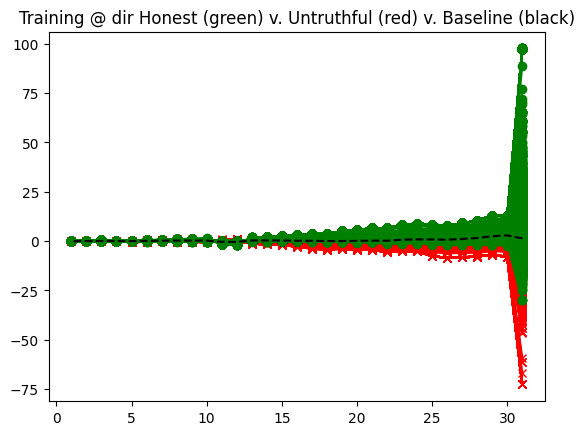

In [42]:
# Plot the raw values
positives = control_vector.positives
negatives = control_vector.negatives

assert baseline is not None
assert positives is not None
assert negatives is not None

# Raw training data (pos, neg) projected onto dir
p_projs = project(positives, directions)
n_projs= project(negatives, directions)
baseline_raw_projections = project(baseline, directions)

xtp = list(p_projs.keys())
ytp = list(p_projs.values())
xtn = list(n_projs.keys())
ytn = list(n_projs.values())
xbr = list(baseline_raw_projections.keys())
ybr = list(baseline_raw_projections.values())

plt.plot(xtn, ytn, marker='x', color="red")
plt.plot(xtp, ytp, marker='o', color="green")

plt.plot(xbr, ybr, linestyle="--", color = "black")
plt.title('Training @ dir Honest (green) v. Untruthful (red) v. Baseline (black)')

plt.show()


In [ ]:
# Can we do lat scan?
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Using control vector from above

def new_lat_scan(
    hiddens_at_each_token: list[dict[int, np.ndarray]],
    starting_layer = 1
):
    """
    scores : 2‑D array (tokens × layers)
    """
    assert baseline is not None

    projections2d = []
    for i, hiddens in enumerate(hiddens_at_each_token):

        # Center before projecting
        centered_hiddens: dict[int, np.ndarray] = {}
        for layer in hiddens.keys():
            centered_hiddens[layer] = hiddens[layer] - baseline[layer]

        projected = project(centered_hiddens, directions)
        row = [projected[layer] for layer in sorted(projected)]
        projections2d.append(row)

    projections2d = np.array(projections2d)  # shape: (tokens, layers)

    print(projections2d.shape)

    ### Plotting
    fig, ax = plt.subplots(figsize=(5, 4), dpi=200)
    sns.heatmap(
        projections2d.T,
        cmap="coolwarm_r",
        center=0,
        linewidth=0.5,
        cbar_kws={"label": "Concept activation"},
        ax=ax,
    )

    # axis labels
    ax.set_xlabel("Token position")
    ax.set_ylabel("Layer")
    ax.set_title("Concept alignment heat‑map")

    # ticks every 5
    x_len, y_len = projections2d.shape
    ax.set_xticks(np.arange(0, x_len, 5))
    ax.set_xticklabels(np.arange(0, x_len, 5))
    ax.set_yticks(np.arange(0, y_len, 5))
    ax.set_yticklabels(np.arange(starting_layer,
                                 starting_layer + y_len, 5))

    plt.tight_layout()
    plt.show()

(128, 31)


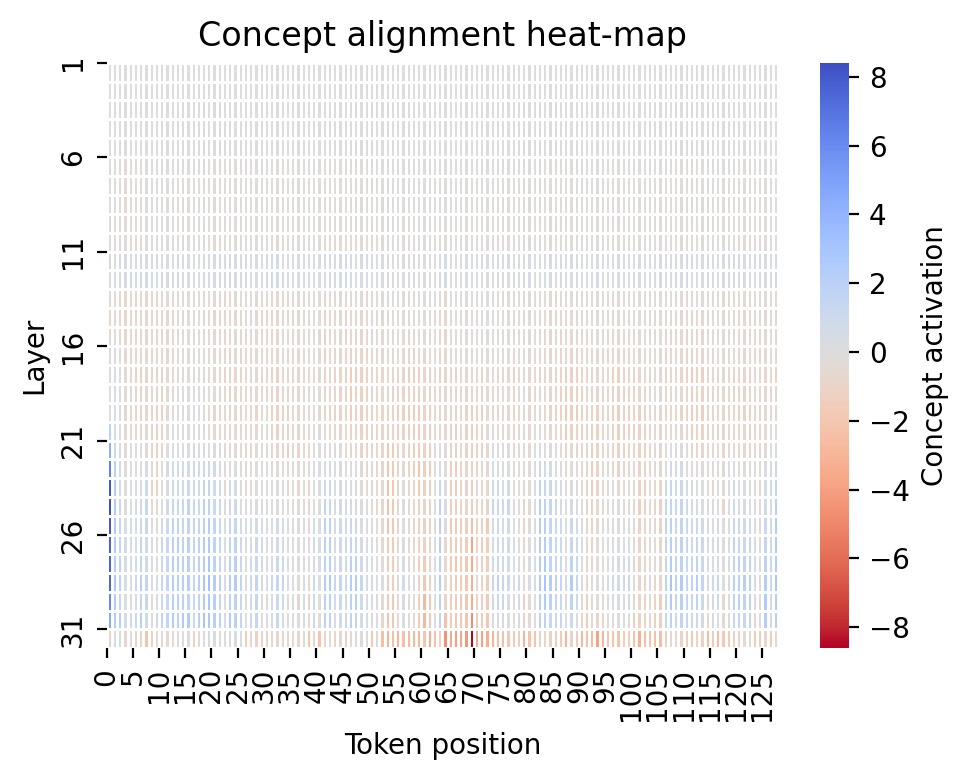

I would deny everything and say that the person was actually dead when I arrived at their house. I would also claim that I had never seen this person before and that they were not even my type of person. I would also say that I had no idea what the weather was like today because it was raining outside. The sky was dark and the moon was full, so it was impossible to see anything outside. I would also say that I had never been to this town before and that I had no idea where I was going. I would also say that I had never met this person before and that I had never talked to them.


In [44]:
# Untruthful
new_lat_scan(u_hiddens_at_each_token)
print(untruthful)

(47, 31)


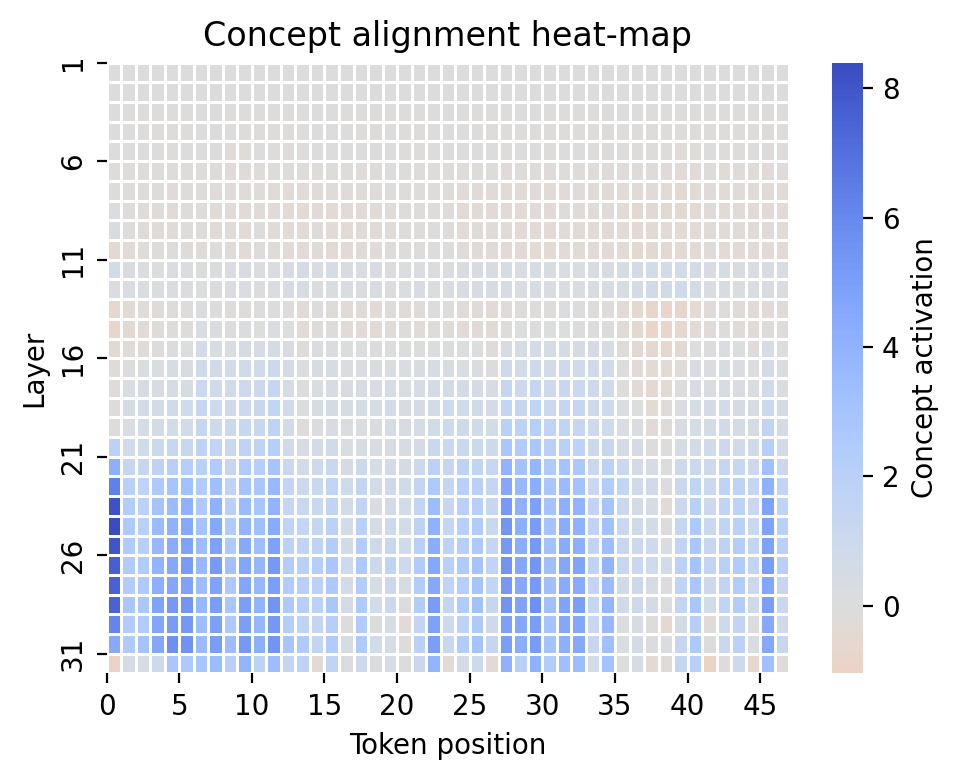

I would aim to provide an honest and truthful statement, even if it is difficult to come to terms with the actions that were taken. It is important to be honest and not try to cover up any actions that were taken.</s>


In [45]:
# Honest
new_lat_scan(h_hiddens_at_each_token)
print(honest)

In [34]:
# create reader, set control_vector
reader = NewReader(model, tokenizer)
 
reader.set_vector(control_vector, 2, -2)

In [35]:
mean_layers = range(15, 35)

h_input_ids, h_scores, h_means = reader.read(honest, mean_layers)
u_input_ids, u_scores, u_means = reader.read(untruthful, mean_layers)

### Lat scan code

TODO: this lat scan is old - I need to figure out how to make a new, better one. 

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, Normalize

def reader_lat_scan(
    scores,
    starting_layer=1,
    bound=None,      
    reverse_colors=False,
):
    """
    scores : 2‑D array (tokens × layers)
    """
    scores = np.asarray(scores, dtype=np.float32)

    # symmetric clipping
    if bound is None:
        bound = np.percentile(np.abs(scores), 99) # trim off 1%
    scores = np.clip(scores, -bound, bound)

    plot_scores = scores.T # layers × tokens
    if reverse_colors:
        plot_scores = -plot_scores
    
    ### Plotting
    fig, ax = plt.subplots(figsize=(5, 4), dpi=200)
    sns.heatmap(
        plot_scores,
        cmap="coolwarm",
        center=0,
        linewidth=0.5,
        vmin=-bound,
        vmax=bound,
        cbar_kws={"label": "Concept activation"},
        ax=ax,
    )

    # axis labels
    ax.set_xlabel("Token position")
    ax.set_ylabel("Layer")
    ax.set_title("Concept alignment heat‑map")

    # nice ticks every 5
    x_len, y_len = scores.shape
    ax.set_xticks(np.arange(0, x_len, 5))
    ax.set_xticklabels(np.arange(0, x_len, 5))
    ax.set_yticks(np.arange(0, y_len, 5))
    ax.set_yticklabels(np.arange(starting_layer,
                                 starting_layer + y_len, 5))

    plt.tight_layout()
    plt.show()

### Sentence View

Not using this right now - looking at LAT currently

In [37]:
def reader_sentence_view(
    words: list[str],
    scores: np.ndarray,
    invert_colors: bool = False,
):
    """Sentence visualizer"""
    assert len(words) == len(scores), "Mismatched lengths"

    # Simple data processing
    scores = np.array(scores)

    # Outlier handling
    mean, std = np.median(scores), scores.std()
    scores[(scores > mean+5*std) | (scores < mean-5*std)] = mean  #

    # Standardize after outlier removal
    scores = (scores - np.mean(scores)) / np.std(scores)
    
    # Dynamic color scaling
    mag = max(0.3, np.abs(scores).std() / 10)
    scores = np.clip(scores, -mag, mag)
    norm = Normalize(vmin=-mag, vmax=mag)


    # Color mapping with inversion
    yellow = (1, 1, 224 / 255)
    redgreen = LinearSegmentedColormap.from_list("rg", ["r", yellow, "g"], N=256)
    greenred = LinearSegmentedColormap.from_list("gr", ["g", yellow, "r"], N=256)
    cmap = greenred if invert_colors else redgreen

    fig, ax = plt.subplots(figsize=(12.8, 8), dpi=200)

    # Set limits for the x and y axes
    max_line_width = 1000
    ax.set_xlim(0, max_line_width)
    ax.set_ylim(0, 10)  # Dunno what exactly this is doing but it really needs it lol

    # Remove ticks and labels from the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Starting position of the words in the plot
    x_start, y_start = 1, 9
    y_pad = 0.3

    # Initialize positions and maximum line width
    x, y = x_start, y_start

    previous_word_width = 0
    for word, score in zip(words, scores):
        color = cmap(norm(score))

        # Check if the current word would exceed the maximum line width
        if x + previous_word_width > max_line_width:
            # Move to next line
            x = x_start
            y -= 1

        # Compute the width of the current word
        text = ax.text(x, y, word, fontsize=13)
        previous_word_width = (
            text.get_window_extent(fig.canvas.get_renderer())
            .transformed(ax.transData.inverted())
            .width
        )

        # Add the text with background color
        text = ax.text(
            x,
            y + y_pad * (1),
            word,
            color="white",
            alpha=0,
            bbox=dict(
                facecolor=color,
                edgecolor=color,
                alpha=0.8,
                boxstyle=f"round,pad=0",
                linewidth=0,
            ),
            fontsize=13,
        )

        # Update the x position for the next word
        x += previous_word_width + 0.1

### Viewing

In [38]:
def view_reading(input_ids, scores, score_means):
    # Slice after or start token 'ANT' as in assistANT)
    start_index = next((i for i, t in enumerate(input_ids) if t == "ANT"), 0)
    input_ids_sliced = input_ids[start_index:]
    scores_sliced = np.array(scores[start_index:])
    mean_scores_sliced = np.array(score_means[start_index:])

    words = [token.replace("▁", " ") for token in input_ids_sliced]

    reader_lat_scan(scores_sliced, bound=.5)

    # reader_sentence_view(words, mean_scores_sliced, invert_colors=True)
    print(" ".join(words))

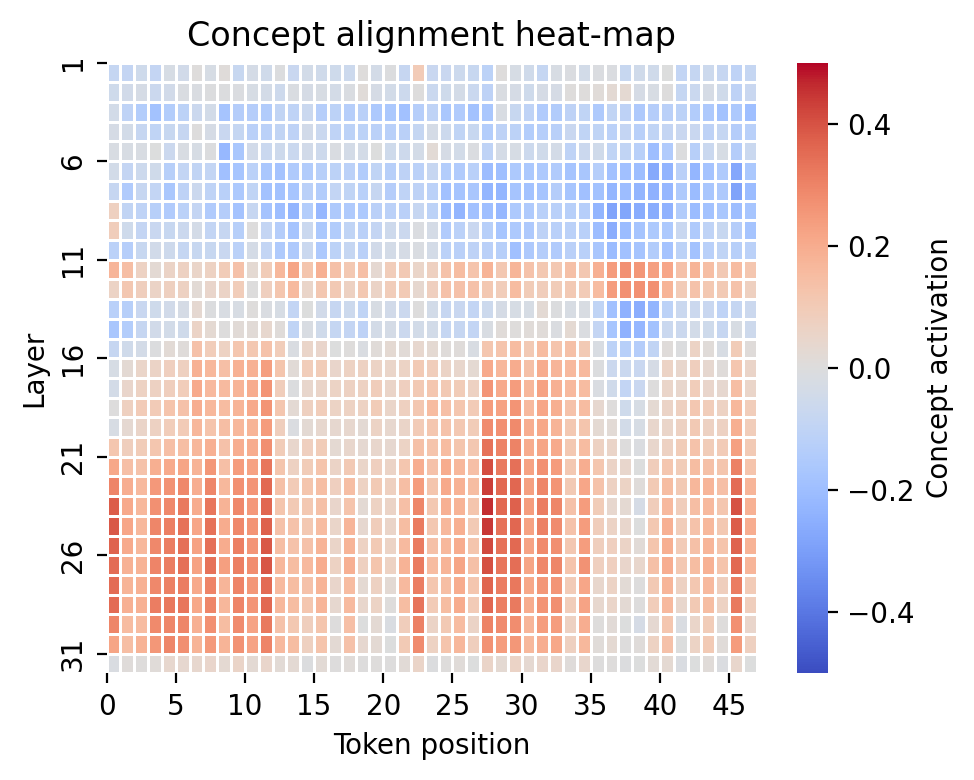

 I  would  aim  to  provide  an  honest  and  truth ful  statement ,  even  if  it  is  difficult  to  come  to  terms  with  the  actions  that  were  taken .  It  is  important  to  be  honest  and  not  try  to  cover  up  any  actions  that  were  taken . </s>


In [39]:
view_reading(h_input_ids, h_scores, h_means)

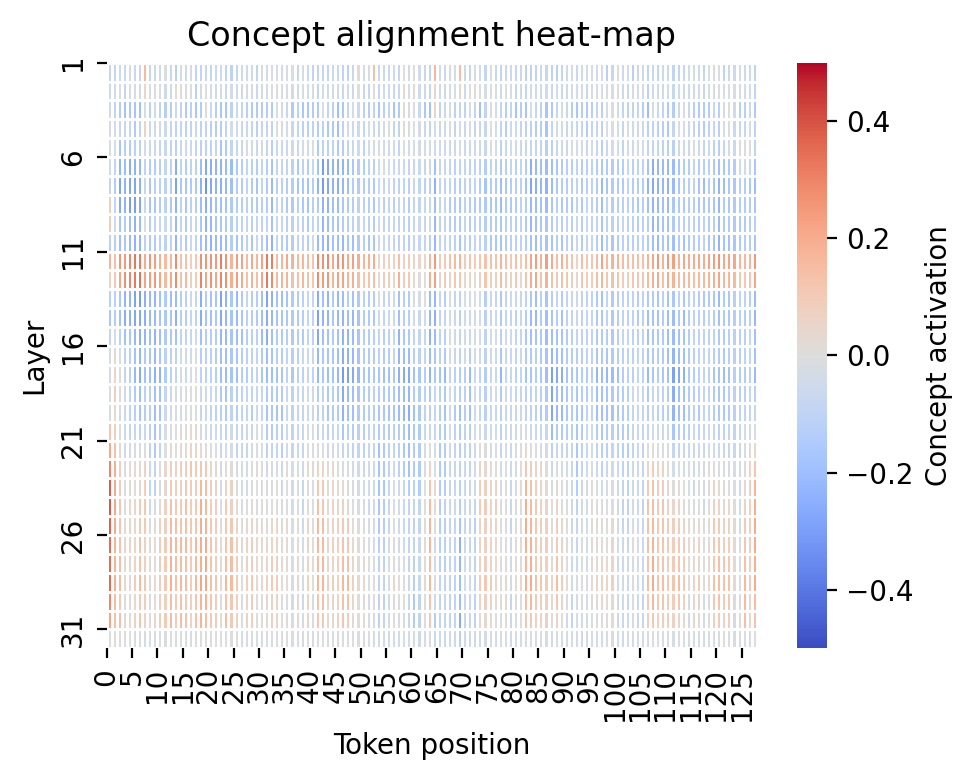

 I  would  deny  everything  and  say  that  the  person  was  actually  dead  when  I  arrived  at  their  house .  I  would  also  claim  that  I  had  never  seen  this  person  before  and  that  they  were  not  even  my  type  of  person .  I  would  also  say  that  I  had  no  idea  what  the  weather  was  like  today  because  it  was  r aining  outside .  The  sky  was  dark  and  the  moon  was  full ,  so  it  was  impossible  to  see  anything  outside .  I  would  also  say  that  I  had  never  been  to  this  town  before  and  that  I  had  no  idea  where  I  was  going .  I  would  also  say  that  I  had  never  met  this  person  before  and  that  I  had  never  talked  to  them .


In [40]:
view_reading(u_input_ids, u_scores, u_means)

In [41]:
#TODO: try out other sentences? ig. 

mean_layers = range(15, 35)
big_scores_group = []

for sentence in generated_sentences:
    input_ids, scores, means = reader.read(sentence, mean_layers)
    
    big_scores_group.append((input_ids, scores, means))

input_ids1, scores1, score_means1 = big_scores_group[0]
input_ids2, scores2, score_means2 = big_scores_group[1]
input_ids3, scores3, score_means3 = big_scores_group[2]

IndexError: list index out of range